# State Distribution Example

In this example, we plan to plot the distribution of system states. This helps researchers on serverless computing platforms to debug and test out their performance models with knowledge of system state distribution.

In [1]:
# imports

%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from pacssim.ServerlessSimulator import ServerlessSimulator as Sim

sim = Sim(arrival_rate=0.9, warm_service_rate=1/2.016, cold_service_rate=1/2.163,
            expiration_threshold=600, max_time=100000)
sim.generate_trace(debug_print=False)
sim.print_trace_results()

Cold Starts / total requests: 	 117 / 90216
Cold Start Probability: 	 0.0013
Rejection / total requests: 	 0 / 90216
Rejection Probability: 	 0.0000
Average Instance Life Span: 	 6704.5661
Average Server Count:  		 7.6123
Average Running Count:  	 1.8273
Average Idle Count:  		 5.7850


You can define any state representation you want based on the data present in the trace.
Here, we chose to use the number of servers as state.

In [3]:
sim.calculate_time_lengths()

# encode states
hist_states = []
for idx in range(len(sim.hist_server_count)):
    if sim.hist_server_count[idx] == 0:
        hist_states.append((0, 'd'))
    else:
        curr_server_count = sim.hist_server_count[idx]
        prev_server_count = sim.hist_server_count[idx-1]
        if curr_server_count > prev_server_count:
            hist_states.append((curr_server_count, 'u'))
        elif curr_server_count < prev_server_count:
            hist_states.append((curr_server_count, 'd'))
        else: # state hasn't changed
            hist_states.append(hist_states[-1])

vals, probs = sim.calculate_time_average(hist_states, skip_init_time=100)
sim.print_time_average(vals, probs)
pd.DataFrame(data = {'state': vals, 'prob': probs})

Value           Prob
(7, 'u')        0.1671
(6, 'd')        0.0528
(9, 'u')        0.1484
(10, 'u')       0.0000
(9, 'd')        0.0001
(8, 'd')        0.0181
(11, 'u')       0.0060
(10, 'd')       0.0000
(7, 'd')        0.2803
(8, 'u')        0.3273


,state,prob
0,"(7, u)",0.167144
1,"(6, d)",0.052754
2,"(9, u)",0.148352
3,"(10, u)",0.000001
4,"(9, d)",0.000071
5,"(8, d)",0.018091
6,"(11, u)",0.006007
7,"(10, d)",0.000009
8,"(7, d)",0.280318
9,"(8, u)",0.327253


Value           Prob
6               0.0528
7               0.4475
8               0.3453
9               0.1484
10              0.0000
11              0.0060


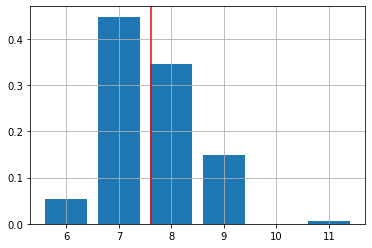

In [4]:
sim.calculate_time_lengths()

unq_vals, val_times = sim.calculate_time_average(sim.hist_server_count, skip_init_time=100)

plt.bar(unq_vals, val_times)
plt.grid(True)
plt.axvline(x=sim.get_average_server_count(), c='r')

sim.print_time_average(unq_vals, val_times)

In [5]:
pd.DataFrame(data = {
    'server_count': unq_vals,
    'Probability': val_times
})

,server_count,Probability
0,6,0.052754
1,7,0.447462
2,8,0.345344
3,9,0.148423
4,10,0.000010
5,11,0.006007
